# Evaluate performance

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

import shap

from scipy.stats import pearsonr, randint, uniform

import matplotlib.pyplot as plt
import matplotlib.cm

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
# REGION = "NSW"

In [7]:
# REMOVE_WEEKEND = False

In [8]:
# REMOVE_XMAS = False

In [9]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [10]:
# MASK_NAME = "pop_dens_mask"

In [11]:
TIME_COLUMNS = ["is_weekend"]

In [12]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [13]:
FIRST_TEST_YEAR = 2017
LAST_TEST_YEAR = 2019

In [14]:
# N_FEATURES = "best"

In [16]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

In [15]:
def read_results(results_name, mask_name, rm_weekend, rm_xmas, n_features):
    """
    Read in results dataframes as dictionary items
    """
    if results_name == "feature_selection":
        name = "feature_selection_results"
    elif (results_name == "training") | (results_name == "test"):
        name = results_name + "_predictions"
    else:
        name = results_name
        
    results = dict()
    for r in regions:
        filename = fn.get_filename(
            name, MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH, n_features
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + results_name + "/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

# Feature selection

In [31]:
def plot_feature_selection(ax, results, label, pars_results=None, col1="tab:blue", col2="tab:red"):
    """
    Plot average score +/- standard error
    
    ax: axes
    result: pandas dataframe with avg_score and std_dev columns
    label: str, label for legend
    pars_results: pandas dataframe with avg_score and std_dev columns, to mark another point e.g. most parsimonious model
    """
    avg_score = results["avg_score"].values
    se = results["std_err"].values
    score_max = np.where(results["selected_features"] == True)[0][0]
    
    p = ax.plot(avg_score, marker="o", c=col1, zorder=1, label=label)
    ax.fill_between(range(len(se)), avg_score + se, avg_score - se, alpha=0.3, color=col1, zorder=1)
    ax.scatter(range(len(avg_score))[score_max], avg_score[score_max], zorder=2, c=col2, marker="x", s=100)
    
    if pars_results is not None:
        pars_score = np.where(pars_results["selected_features"] == True)[0][0]
        ax.scatter(range(len(avg_score))[pars_score], avg_score[pars_score], zorder=2, c=col2, marker="+", s=100)
    
    ax.axes.grid(zorder=0)
    ax.set_axisbelow(True)
    ax.set_xticks(range(len(avg_score)))
    ax.set_xticklabels(range(1, len(avg_score) + 1))
    ax.set_xlabel("Number of features")
    ax.set_ylabel("neg_mean_absolute_error")
    
    return p

Read data

In [17]:
# Population density mask, all data
features_dict_best = read_results("feature_selection", "pop_dens_mask", False, False, "best")
features_dict_pars = read_results("feature_selection", "pop_dens_mask", False, False, "parsimonious")

In [18]:
features_dict_best["NSW"].head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,selected_features
1,"(15,)",[-12032.12634008 -12709.37474908 -11388.006184...,-11633.182289,['hdd3'],659.204486,682.863092,278.777690,False
2,"(0, 15)",[-8780.50068176 -9163.20407944 -8380.05594135 ...,-8428.676304,"['is_weekend', 'hdd3']",456.297902,472.674265,192.968461,False
3,"(0, 3, 15)",[-6546.42224014 -6888.74937117 -5695.42862145 ...,-6312.857300,"['is_weekend', 'msdwswrf', 'hdd3']",382.056762,395.768638,161.571870,False
4,"(0, 3, 15, 16)",[-5494.42170587 -5813.28549908 -4874.62556786 ...,-5406.481065,"['is_weekend', 'msdwswrf', 'hdd3', 't2m']",342.686297,354.985182,144.922094,False
5,"(0, 3, 8, 15, 16)",[-5381.71894911 -5695.40491658 -4958.46416182 ...,-5251.839213,"['is_weekend', 'msdwswrf', 't2max', 'hdd3', 't...",307.196164,318.221321,129.913310,False


In [19]:
# No mask, all data
features_no_mask_dict_best = read_results("feature_selection", "no_mask", False, False, "best")
features_no_mask_dict_pars = read_results("feature_selection", "no_mask", False, False, "parsimonious")

In [20]:
# Log(population density) mask, all data
features_log_mask_dict_best = read_results("feature_selection", "pop_dens_log_mask", False, False, "best")
features_log_mask_dict_pars = read_results("feature_selection", "pop_dens_log_mask", False, False, "parsimonious")

In [79]:
# Population density mask, remove weekends and Xmas
features_no_wknd_no_xmas_dict_best = read_results("feature_selection", "pop_dens_mask", True, True, "best")
features_no_wknd_no_xmas_dict_pars = read_results("feature_selection", "pop_dens_mask", True, True, "parsimonious")

Selected number of features

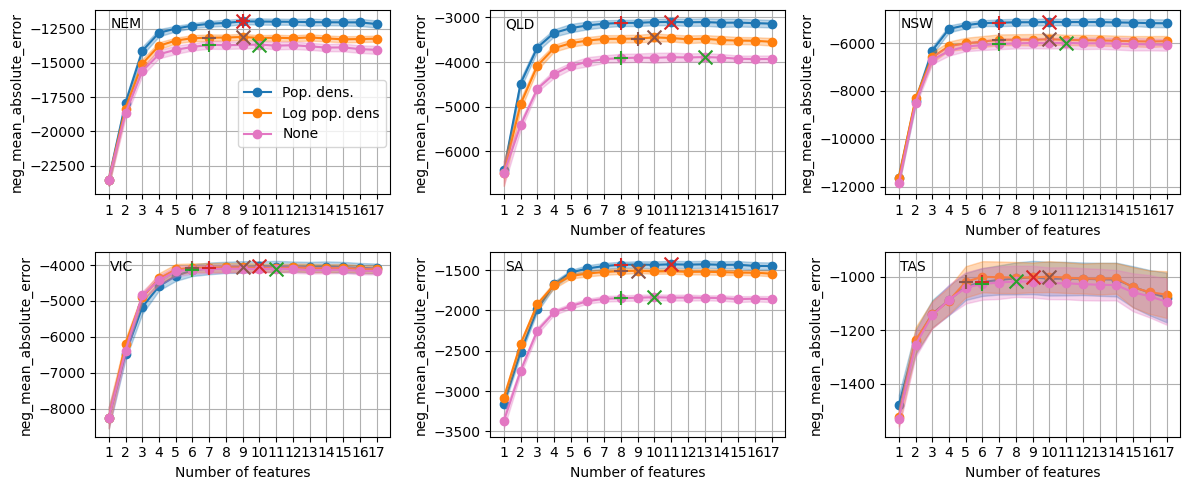

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(12,5))
for i, r in enumerate(regions):
    p1 = plot_feature_selection(
        ax.flatten()[i],
        features_dict_best[r],
        "Pop. dens.",
        features_dict_pars[r]
    )
    p2 = plot_feature_selection(
        ax.flatten()[i],
        features_log_mask_dict_best[r],
        "Log pop. dens",
        features_log_mask_dict_pars[r],
        col1="tab:orange", 
        col2="tab:brown"
    )
    p3 = plot_feature_selection(
        ax.flatten()[i],
        features_no_mask_dict_best[r],
        "None",
        features_no_mask_dict_pars[r],
        col1="tab:pink",
        col2="tab:green"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2, 0.7))
    
plt.tight_layout()

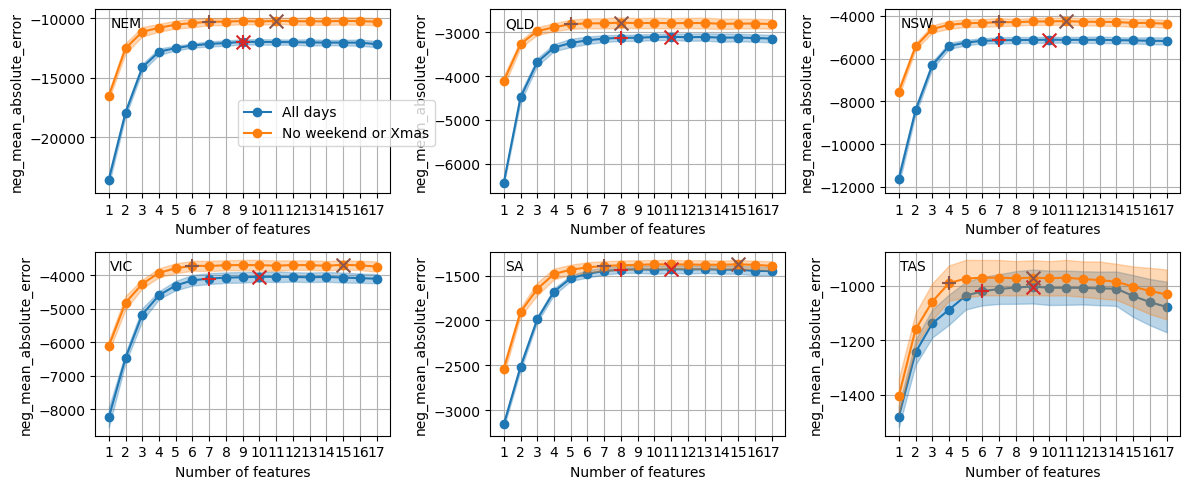

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(12,5))
for i, r in enumerate(regions):
    p1 = plot_feature_selection(
        ax.flatten()[i],
        features_dict_best[r],
        "All days",
        features_dict_pars[r]
    )
    p2 = plot_feature_selection(
        ax.flatten()[i],
        features_no_wknd_no_xmas_dict_best[r],
        "No weekend or Xmas",
        features_no_wknd_no_xmas_dict_pars[r],
        col1="tab:orange",
        col2="tab:brown"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2, 0.7))
    
plt.tight_layout()

# Hyperparameters

In [26]:
# Population density mask, all data
hyperparameters_dict = read_results("hyperparameters", "pop_dens_mask", False, False, "parsimonious")

In [27]:
# Population density mask, remove weekends and Xmas
hyperparameters_no_wknd_no_xmas_dict = read_results("hyperparameters", "pop_dens_mask", True, True, "parsimonious")

In [24]:
hyperparameters_dict

{'NEM':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'QLD':                     0
 max_depth          40
 max_leaf_nodes    143
 min_samples_leaf    8
 n_estimators      282,
 'NSW':                     0
 max_depth          42
 max_leaf_nodes    147
 min_samples_leaf    6
 n_estimators      398,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          28
 max_leaf_nodes    175
 min_samples_leaf    6
 n_estimators      319}

In [25]:
hyperparameters_no_wknd_no_xmas_dict

{'NEM':                     0
 max_depth          37
 max_leaf_nodes    142
 min_samples_leaf    6
 n_estimators      299,
 'QLD':                     0
 max_depth          13
 max_leaf_nodes     65
 min_samples_leaf   10
 n_estimators      247,
 'NSW':                     0
 max_depth          46
 max_leaf_nodes    130
 min_samples_leaf    5
 n_estimators      273,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    156
 min_samples_leaf    6
 n_estimators      409,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          29
 max_leaf_nodes    136
 min_samples_leaf    8
 n_estimators      336}

# Predictions

In [85]:
def get_scores(res_dict, metrics, metric_names):
    """
    Compute the scores for each region in res_dict.
    """
    df = pd.DataFrame(index=res_dict.keys(), columns=metric_names)
    for r in res_dict.keys():
        scores = fn.compute_scores(res_dict[r]["observation"], res_dict[r]["prediction"], metrics)
        df.loc[r] = [scores[i] for i in range(-1, 5)]
    return df

In [87]:
# Population density mask, all data
training_dict_best = read_results("training", "pop_dens_mask", False, False, "best")
training_dict_pars = read_results("training", "pop_dens_mask", False, False, "parsimonious")

test_dict_best = read_results("test", "pop_dens_mask", False, False, "best")
test_dict_pars = read_results("test", "pop_dens_mask", False, False, "parsimonious")

In [81]:
# Population density mask, remove weekends and Xmas
training_no_wknd_no_xmas_dict_pars = read_results("training", "pop_dens_mask", True, True, "parsimonious")
test_no_wknd_no_xmas_dict_pars = read_results("test", "pop_dens_mask", True, True, "parsimonious")

In [82]:
metric_names = ["r", "R2", "MAE", "MSE", "MAPE", "MedAE"]

In [83]:
# scikit learn metrics (correlation will be computed too, within fn.compute_scores)
sklearn_metrics = [
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error
]

In [88]:
training_scores_best = get_scores(training_dict_best, sklearn_metrics, metric_names)
training_scores_pars = get_scores(training_dict_pars, sklearn_metrics, metric_names)
training_no_wknd_no_xmas_scores_pars = get_scores(training_no_wknd_no_xmas_dict_pars, sklearn_metrics, metric_names)

In [89]:
test_scores_best = get_scores(test_dict_best, sklearn_metrics, metric_names)
test_scores_pars = get_scores(test_dict_pars, sklearn_metrics, metric_names)
test_no_wknd_no_xmas_scores_pars = get_scores(test_no_wknd_no_xmas_dict_pars, sklearn_metrics, metric_names)

In [51]:
training_scores_best

,r,R2,MAE,MSE,MAPE,MedAE
NEM,0.932034,0.866484,9521.779598,175505934.066376,0.018473,7577.281052
QLD,0.931507,0.86611,2451.406467,11823122.234653,0.016974,1913.966477
NSW,0.93749,0.877325,4132.510774,33206067.566447,0.021654,3258.360571
VIC,0.940936,0.88285,3160.025575,18671038.447404,0.0256,2489.066463
SA,0.955216,0.90952,1121.985758,2175868.897163,0.034057,915.514437
TAS,0.90252,0.81183,814.403074,1106720.028912,0.030919,661.494145


In [52]:
test_scores_best

,r,R2,MAE,MSE,MAPE,MedAE
NEM,0.90781,0.820572,11918.733227,263079397.714663,0.022613,9218.617925
QLD,0.934597,0.854947,3412.001825,20747627.184303,0.022696,2612.040113
NSW,0.926699,0.853338,4769.936786,46716520.204119,0.024152,3500.300996
VIC,0.905771,0.816786,4289.530688,33410981.322426,0.03429,3298.42303
SA,0.926492,0.856454,1584.795002,4069031.11206,0.047153,1334.424447
TAS,0.882104,0.774913,957.582233,1445410.321275,0.035955,788.071346


In [90]:
def barplot(ax, metric, train_df, test_df):
    """
    Barplot of metric for each region
    """
    x = range(17)

    y = np.full(17, np.nan)
    y[[0, 3, 6, 9, 12, 15]] = train_df[metric]
    y[[1, 4, 7, 10, 13, 16]] = test_df[metric]

    colors = [matplotlib.cm.get_cmap("Pastel2")(j) for j in range(6) for _ in range(3)]

    ax.bar(x, y, color=colors)
    
    xticks = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16]
    ax.set_xticks(xticks)
    ax.set_xticklabels(["Train", "Test"] * 6, rotation=45)
    
    ax.set_ylabel(metric)

    # for ix, r in zip([xticks[i] for i in range(0, len(xticks), 2)], training_scores.index):
    #     ax.text(ix, -0.15, r)
    
    for ix, r in zip([0.04, 0.2, 0.35, 0.54, 0.71, 0.87], train_df.index):
        ax.text(ix, -0.35, r, transform=ax.transAxes)

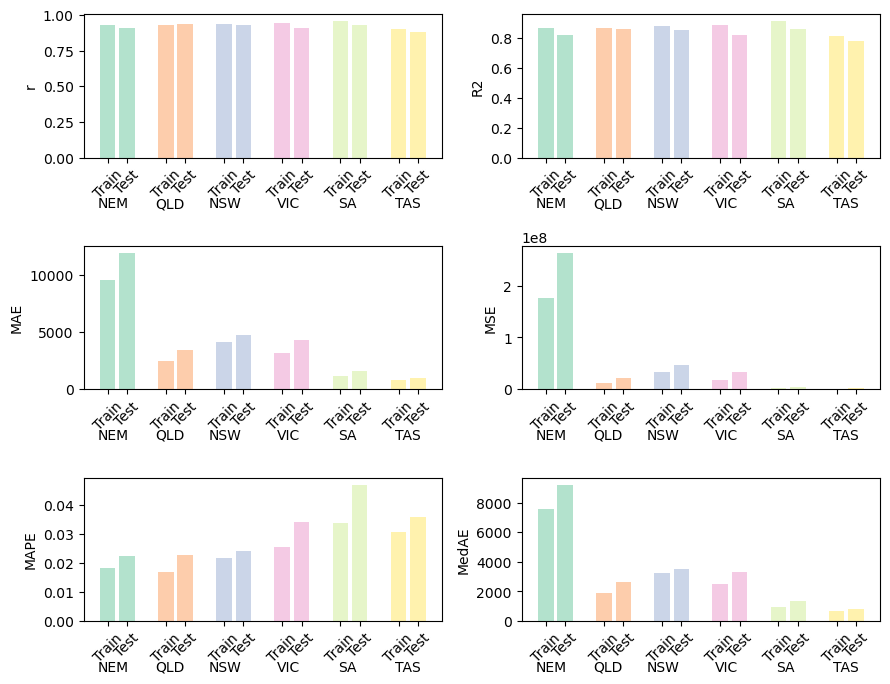

In [60]:
fig, ax = plt.subplots(3, 2, figsize=(9, 7))

for i, m in enumerate(metric_names):
    barplot(ax.flatten()[i], m, training_scores_best, test_scores_best)
    
plt.tight_layout()

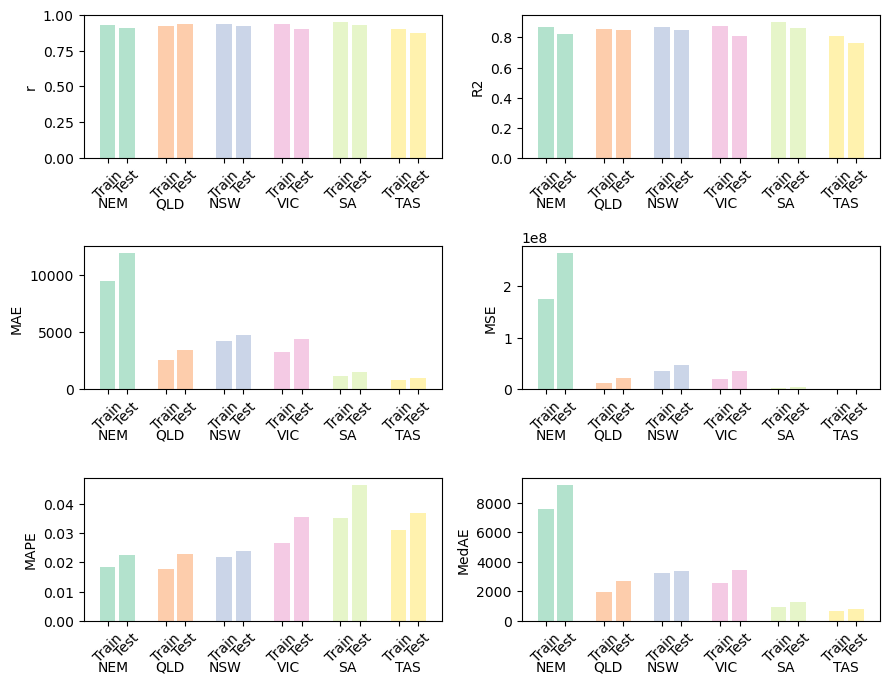

In [91]:
fig, ax = plt.subplots(3, 2, figsize=(9, 7))

for i, m in enumerate(metric_names):
    barplot(ax.flatten()[i], m, training_scores_pars, test_scores_pars)
    
plt.tight_layout()

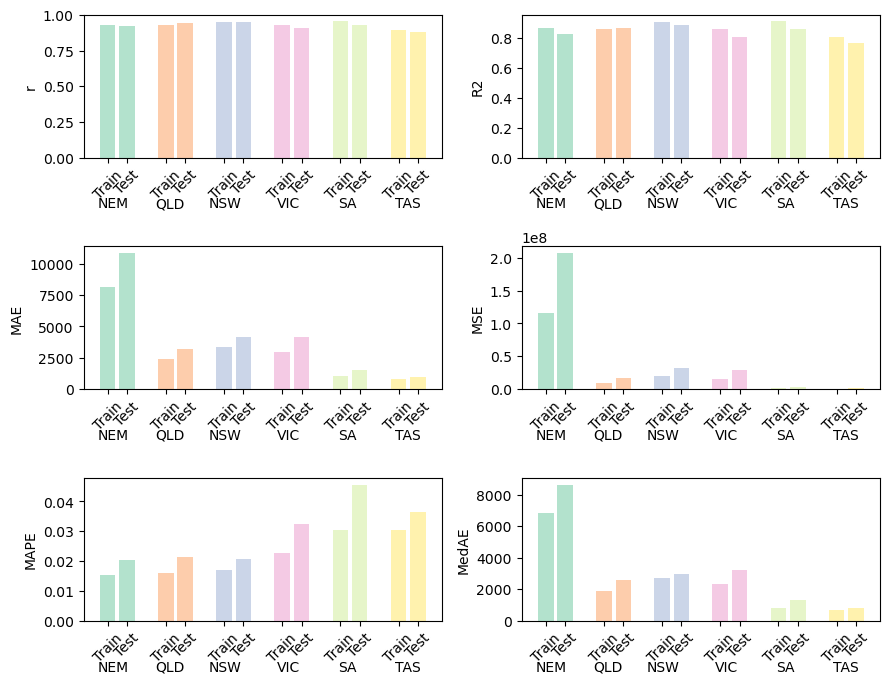

In [92]:
fig, ax = plt.subplots(3, 2, figsize=(9, 7))

for i, m in enumerate(metric_names):
    barplot(ax.flatten()[i], m, training_no_wknd_no_xmas_scores_pars, test_no_wknd_no_xmas_scores_pars)
    
plt.tight_layout()

### Time series

In [94]:
def plot_ts(ax, region, tra_dict, tes_dict, start=None, end=None):
    """
    Plot observation and prediction time series for a region, for a specified period.
    """
    y = pd.concat([tra_dict[region], tes_dict[region]])
    y.index = pd.to_datetime(y.index)
    y = y / 1000 # MWh to GWh

    y.loc[slice(start, end)].plot(ax=ax)
    ax.axvline(pd.Timestamp("2017"), color="k")
    ax.set_ylabel("GWh per day")
    ax.legend(loc="lower left")
    ax.text(0.01, 0.9, region, transform=ax.transAxes)

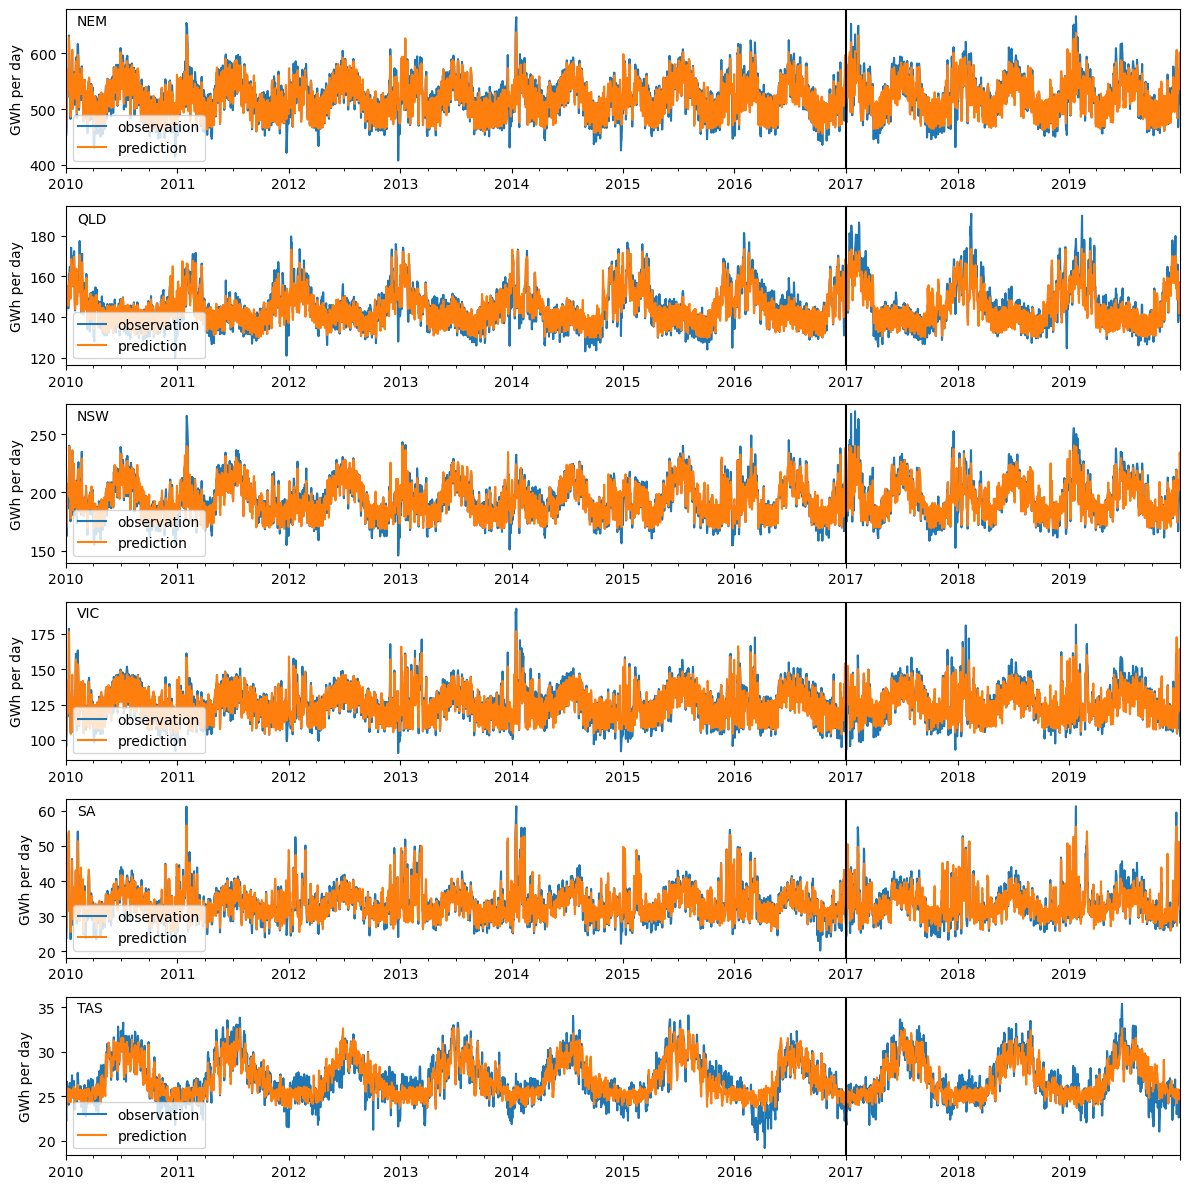

In [63]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_dict_pars, test_dict_pars)
plt.tight_layout()

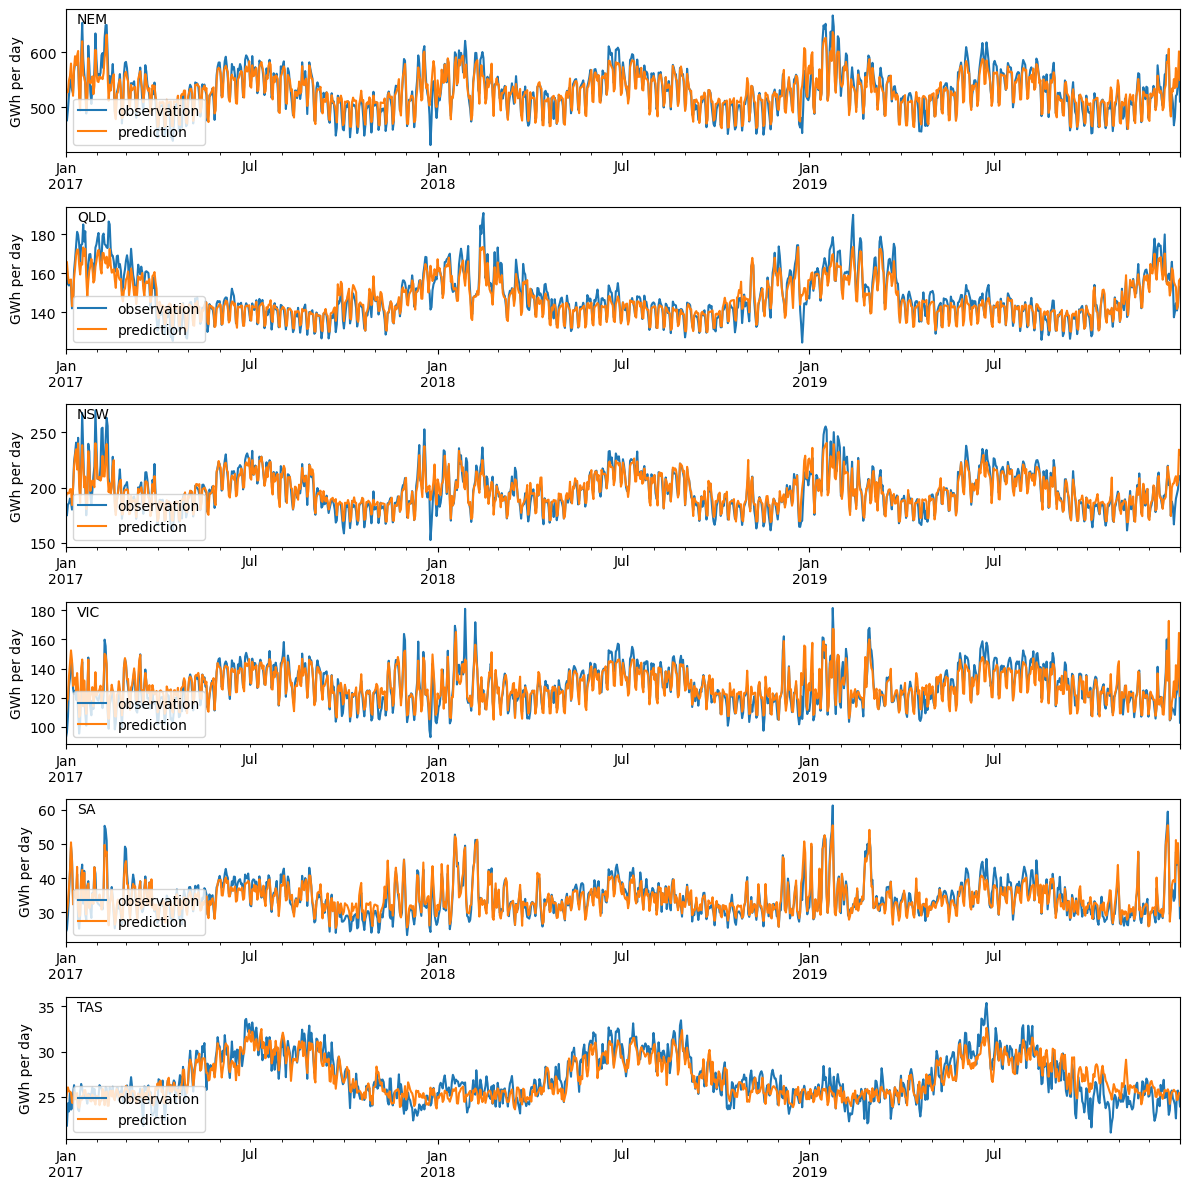

In [64]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_dict_pars, test_dict_pars, start="2017", end="2020")
plt.tight_layout()

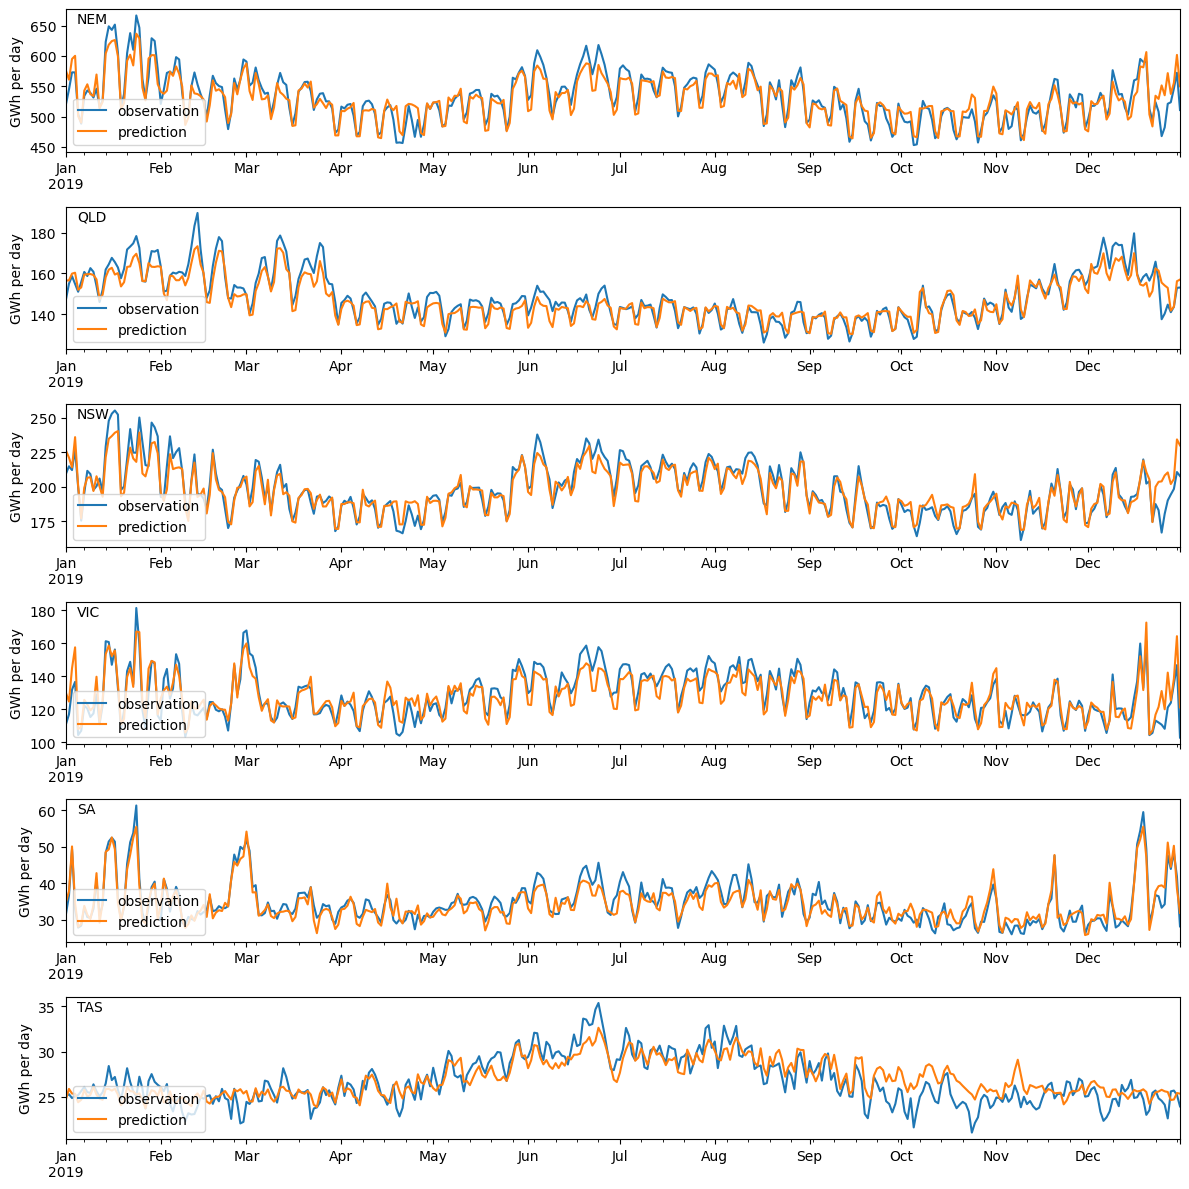

In [65]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_dict_pars, test_dict_pars, start="2019", end="2020")
plt.tight_layout()

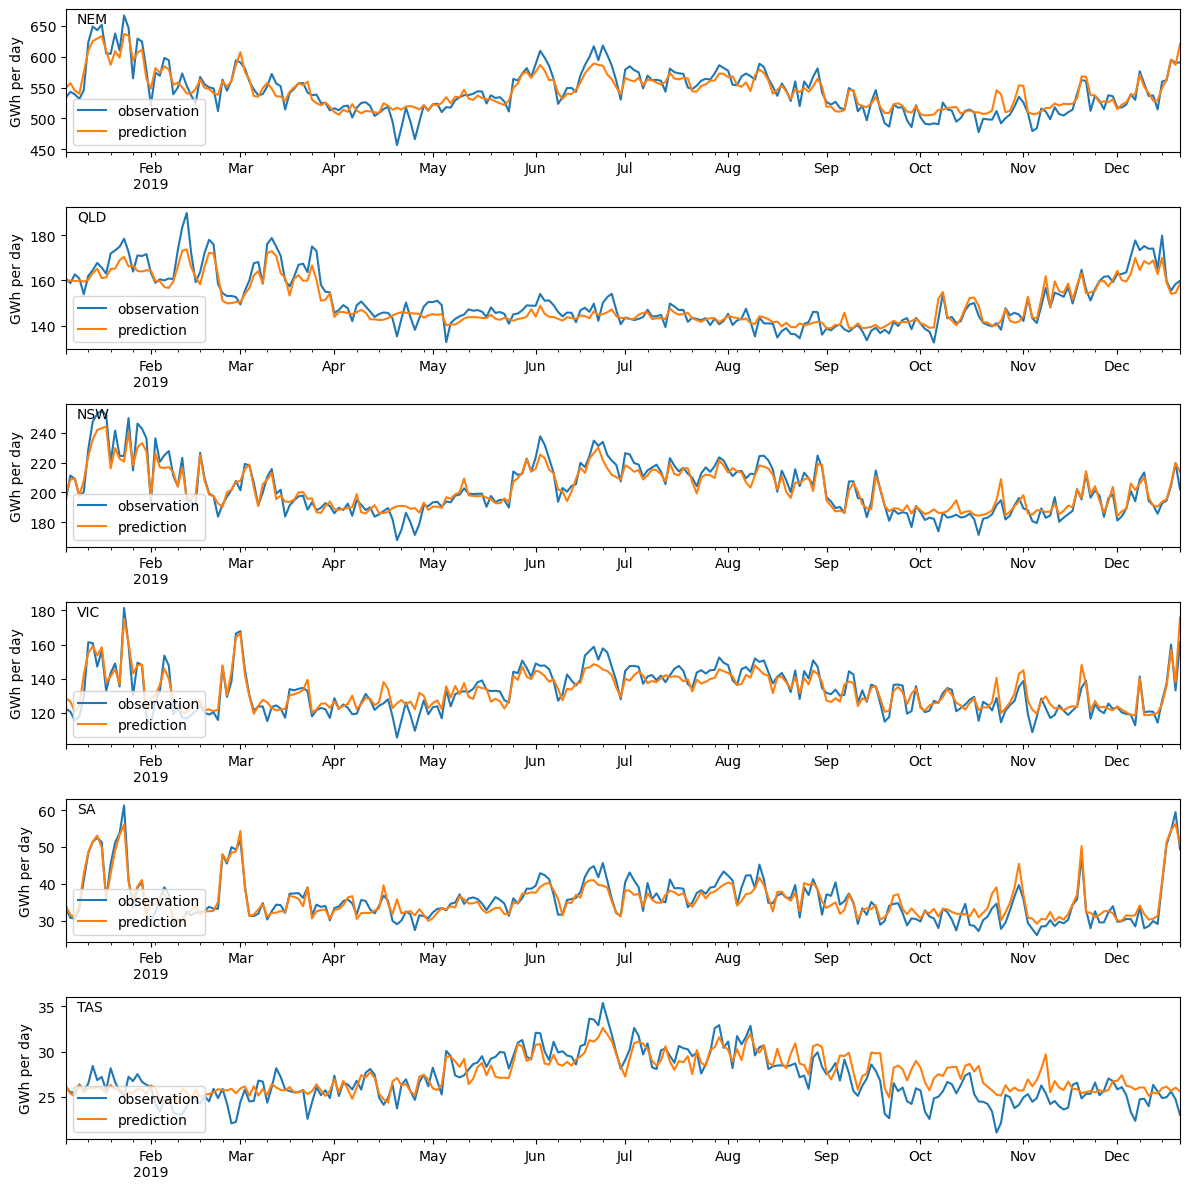

In [95]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_no_wknd_no_xmas_dict_pars, test_no_wknd_no_xmas_dict_pars, start="2019", end="2020")
plt.tight_layout()

### Obs vs. predictions

In [96]:
def get_error(df):
    """
    Error of predictions
    """
    return df["observation"] - df["prediction"]

In [97]:
def plot_scatter(ax, df, color, c=None, cmap=None):
    """
    Plot pred vs obs
    """
    df = df.copy() / 1000
    
    ax.scatter(df["observation"], df["prediction"], c=c, cmap=cmap, color=color, alpha=0.5)
    ax.plot(
        [df.min(), df.max()], [df.min(), df.max()],
        c="k", ls="-"
    )

In [98]:
def plot_fit(df):
    """
    Plot pred vs obs and error histogram
    """
    fig, ax = plt.subplots(1, 2, figsize=(7,3))
        
    plot_scatter(ax[0], df)
    
    err = get_error(df)
    ax[1].hist(err, "fd")

In [99]:
def select_weekend(df):
    """
    Return weekend days of df
    """
    return df.loc[pd.to_datetime(df.index).dayofweek > 4]

In [100]:
def select_weekday(df):
    """
    Return weekdays of df
    """
    return df.loc[pd.to_datetime(df.index).dayofweek <5]

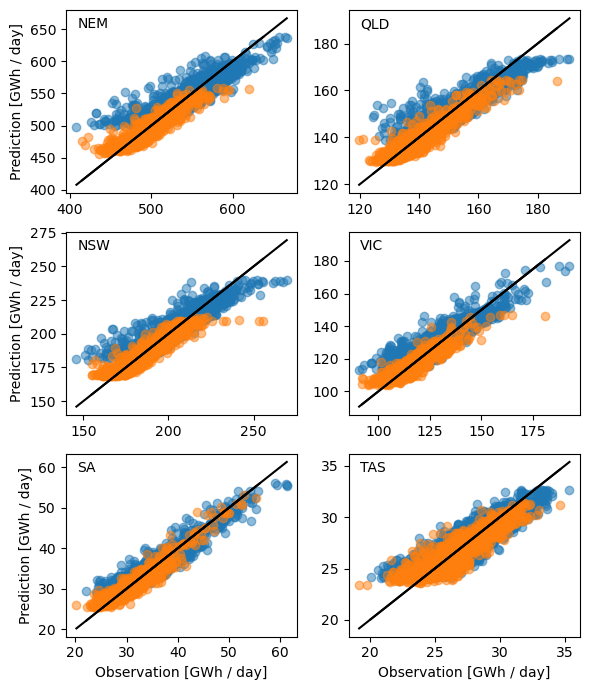

In [101]:
fig, ax = plt.subplots(3, 2, figsize=(6,7))

for i, r in enumerate(regions):
    plot_scatter(
        ax.flatten()[i],
        select_weekday(
            pd.concat([training_dict_pars[r], test_dict_pars[r]], axis=0)
        ),
        color="tab:blue"
    )
    plot_scatter(
        ax.flatten()[i],
        select_weekend(
            pd.concat([training_dict_pars[r], test_dict_pars[r]], axis=0)
        ),
        color="tab:orange"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
for i in [0, 2, 4]:
    ax.flatten()[i].set_ylabel("Prediction [GWh / day]")
for i in [-1, -2]:
    ax.flatten()[i].set_xlabel("Observation [GWh / day]")
    
plt.tight_layout()

In [102]:
# Prepare predictors
files = fn.get_predictor_files(MARKET, "pop_dens_mask")

In [103]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [104]:
t2m = pred_ds["t2m"].sel(
    time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TEST_YEAR))
).compute()

In [105]:
rh = pred_ds["rh"].sel(
    time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TEST_YEAR))
).compute()

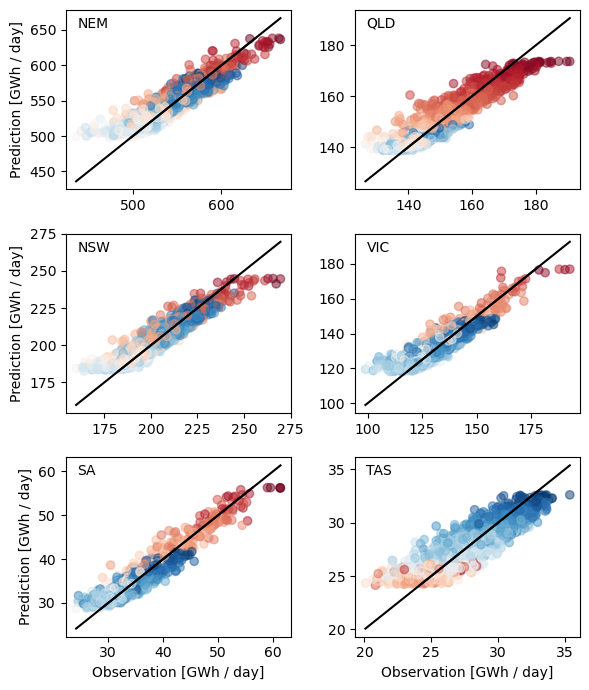

In [109]:
fig, ax = plt.subplots(3, 2, figsize=(6,7))

for i, r in enumerate(regions):
    plot_scatter(
        ax.flatten()[i],
        select_weekday(
            pd.concat([training_no_wknd_no_xmas_dict_pars[r], test_no_wknd_no_xmas_dict_pars[r]], axis=0)
        ),
        color=None,
        c=fn.remove_time(t2m.sel(region=r), True, True, 0),
        cmap="RdBu_r"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
for i in [0, 2, 4]:
    ax.flatten()[i].set_ylabel("Prediction [GWh / day]")
for i in [-1, -2]:
    ax.flatten()[i].set_xlabel("Observation [GWh / day]")
    
plt.tight_layout()

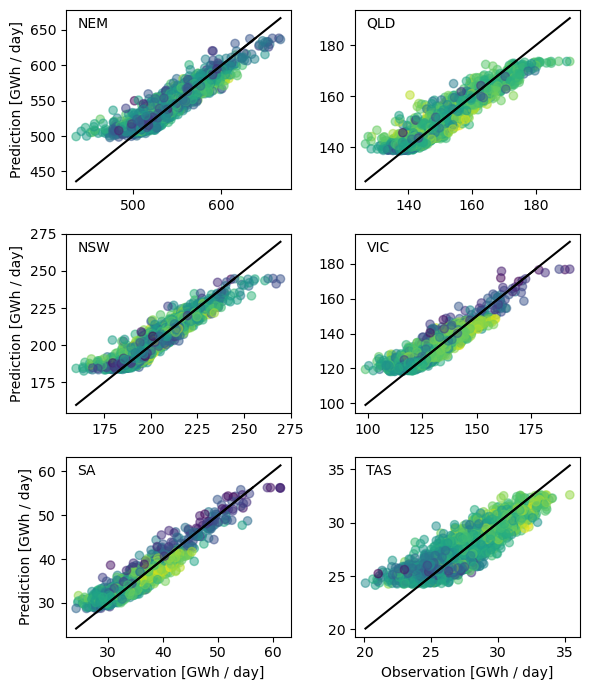

In [112]:
fig, ax = plt.subplots(3, 2, figsize=(6,7))

for i, r in enumerate(regions):
    plot_scatter(
        ax.flatten()[i],
        select_weekday(
            pd.concat([training_no_wknd_no_xmas_dict_pars[r], test_no_wknd_no_xmas_dict_pars[r]], axis=0)
        ),
        color=None,
        c=fn.remove_time(rh.sel(region=r), True, True, 0),
        cmap="viridis"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
for i in [0, 2, 4]:
    ax.flatten()[i].set_ylabel("Prediction [GWh / day]")
for i in [-1, -2]:
    ax.flatten()[i].set_xlabel("Observation [GWh / day]")
    
plt.tight_layout()

# Permutation importances - Need to fit model again using hyperparameters saved

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [114]:
def sel_model(df):
    """
    Select best model from df
    """
    return df.loc[df["selected_features"] == True]

In [115]:
def parse_features(row):
    """
    Parse object to list of strings
    """
    return row.values[0].split("'")[1::2]

In [118]:
dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]
dem_da = fn.remove_time(dem_da, True, True, 0)

In [131]:
da_list = []
for r in regions:
     da_list.append(dem_da.sel(region=r).expand_dims({"region": [r]}))
demand = xr.concat(da_list, "region")

In [120]:
# Prepare predictors
files = fn.get_predictor_files("NEM", "pop_dens_mask")
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [151]:
# Prepare dataframe for machine learning
region_dfs = {}
for r in regions:
    df = fn.to_dataframe(dem_da, pred_ds, r)
    selected_preds = parse_features(sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[:]
    print(selected_preds[::-1])
    df = df[["demand"] + selected_preds[::-1]]
    region_dfs[r] = df

['t2m', 't2m3', 'hdd', 't2max', 'cdd3', 'msdwswrf', 'w10']
['t2m', 'q', 't2max', 'cdd3', 'msdwswrf']
['t2m', 't2m3', 'hdd', 't2max', 'rh', 'msdwswrf', 'w10']
['t2m', 't2m3', 'cdd', 't2max', 'msdwswrf', 'w10']
['t2m', 't2m3', 't2max', 't2m4', 'rh', 'msdwswrf', 'w10']
['t2m3', 'hdd', 'rh', 'w10']


In [155]:
hyperparameters_no_wknd_no_xmas_dict

{'NEM':                     0
 max_depth          37
 max_leaf_nodes    142
 min_samples_leaf    6
 n_estimators      299,
 'QLD':                     0
 max_depth          13
 max_leaf_nodes     65
 min_samples_leaf   10
 n_estimators      247,
 'NSW':                     0
 max_depth          46
 max_leaf_nodes    130
 min_samples_leaf    5
 n_estimators      273,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    156
 min_samples_leaf    6
 n_estimators      409,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          29
 max_leaf_nodes    136
 min_samples_leaf    8
 n_estimators      336}

In [157]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [172]:
perm_train = {}
perm_test = {}

for r in regions:
    test_len = dem_da.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR))).time.values.shape[0]
    
    train_X, test_X, train_y, test_y = fn.split(
        fn.sel_train_test(region_dfs[r], FIRST_TRAIN_YEAR, LAST_TEST_YEAR),
        "demand",
        test_size=test_len,
        random_state=0,
        shuffle=False
    )
    
    rf = ExtraTreesRegressor()

    # Finalise model
    rf = ExtraTreesRegressor(
        n_estimators=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["n_estimators"].values),
        min_samples_leaf=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["min_samples_leaf"].values),
        max_depth=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["max_depth"].values),
        max_leaf_nodes=int(hyperparameters_no_wknd_no_xmas_dict[r].loc["max_leaf_nodes"].values),
        random_state=0,
    )
    
    model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
    model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)
    
    perm_train[r] = fn.perm_imp(
        model_train,
        train_X,
        train_y,
        n_repeats=200,
    )
    perm_test[r] = fn.perm_imp(
        model_test,
        test_X,
        test_y,
        n_repeats=200,
    )

In [177]:
fn.print_perm_imp(
    perm_train[r],
    parse_features(sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[::-1]
)

hdd      0.455 +/- 0.015
t2m3     0.317 +/- 0.011
rh       0.106 +/- 0.005
w10      0.058 +/- 0.003


In [178]:
fn.print_perm_imp(
    perm_test[r],
    parse_features(sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[::-1]
)

hdd      0.402 +/- 0.023
t2m3     0.283 +/- 0.018
rh       0.077 +/- 0.007
w10      0.025 +/- 0.004


In [180]:
parse_features(sel_model(features_no_wknd_no_xmas_dict_pars[r])["feature_names"])[::-1]

['t2m3', 'hdd', 'rh', 'w10']

In [181]:
perm_train[r].importances_mean

array([0.31749413, 0.45498975, 0.10621112, 0.05758322])

In [204]:
perm_train[r]

{'importances_mean': array([0.31749413, 0.45498975, 0.10621112, 0.05758322]),
 'importances_std': array([0.01083417, 0.01527585, 0.00548131, 0.0033673 ]),
 'importances': array([[0.3307481 , 0.3382761 , 0.29305132, 0.31866925, 0.32492864,
         0.30623231, 0.29342708, 0.3225567 , 0.3268268 , 0.3159255 ,
         0.3381425 , 0.3136845 , 0.33734131, 0.3215665 , 0.33436263,
         0.3281787 , 0.32619981, 0.31536733, 0.32137009, 0.29880492,
         0.31451717, 0.31540481, 0.30880422, 0.30540765, 0.32443086,
         0.31159516, 0.32015392, 0.32107641, 0.31252794, 0.32519768,
         0.30905937, 0.29840685, 0.3012451 , 0.33102236, 0.31571961,
         0.31022673, 0.30937584, 0.31073941, 0.31817209, 0.3203071 ,
         0.32028889, 0.31123396, 0.32577524, 0.3044356 , 0.32551072,
         0.30655913, 0.30983171, 0.31796877, 0.31957573, 0.31674831,
         0.31459284, 0.32660622, 0.30419537, 0.32184866, 0.34030536,
         0.30041428, 0.31315888, 0.29943373, 0.31350721, 0.31924288,
  

In [221]:
def scatter_perm(ax, imp_dict, x_nudge, color):
    """
    Scatter importances with mean and std overlaid
    """
    n = imp_dict.importances.shape[-1]
    nx = len(imp_dict.importances_mean)

    ax.scatter(
        [np.repeat(i+x_nudge, n) + np.random.normal(0, 0.05, size=n) for i in range(nx)],
        imp_dict.importances,
        alpha=0.5,
        color=color
    )
    
    # ax.scatter(np.arange(nx)+x_nudge, imp_dict.importances_mean, color="k")
    ax.errorbar(np.arange(nx)+x_nudge, imp_dict.importances_mean, yerr=imp_dict.importances_std, color="k", fmt="o")

In [230]:
def plot_perm(ax, pTrain, pTest, features, x_nudge=0.2, colors=["tab:blue", "tab:orange"]):
    """
    Scatter permutation importantes for train and test
    """
    nx = len(pTrain.importances_mean)
    
    scatter_perm(ax, pTrain, -x_nudge, colors[0])
    scatter_perm(ax, pTest, x_nudge, colors[1])

    ax.set_xticks(range(nx))
    ax.set_xticklabels(parse_features(sel_model(features)["feature_names"])[::-1], rotation=-30)

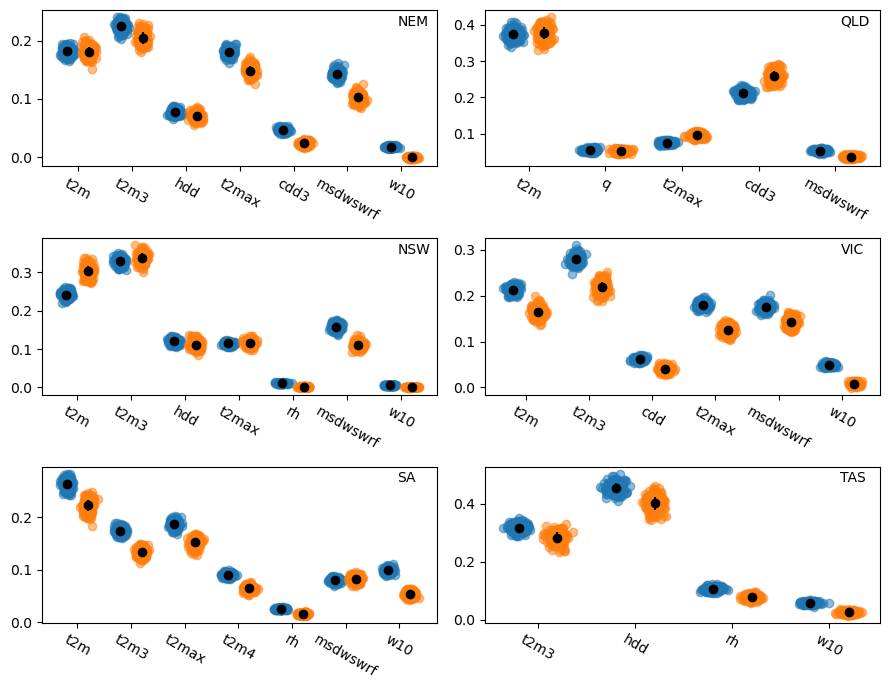

In [232]:
fig, ax = plt.subplots(3, 2, figsize=(9,7))

for i, r in enumerate(regions):
    plot_perm(ax.flatten()[i], perm_train[r], perm_test[r], features_no_wknd_no_xmas_dict_pars[r])
    ax.flatten()[i].text(0.9, 0.9, r, transform=ax.flatten()[i].transAxes)
plt.tight_layout()